In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# !wget https://github.com/explosion/spacy-models/releases/download/en_vectors_web_lg-2.1.0/en_vectors_web_lg-2.1.0.tar.gz -O en_vectors_web_lg-2.1.0.tar.gz
# !pip install en_vectors_web_lg-2.1.0.tar.gz
data_dir = '/content/gdrive/Shareddrives/520_Project'
# !pip install /content/gdrive/Shareddrives/520_Project/en_vectors_web_lg-2.1.0.tar.gz

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import re
import time
import copy
import math
import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optimizer
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import accuracy_score
# import en_vectors_web_lg

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['Times New Roman']
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(font_scale=1.2)

In [ ]:
data = pd.read_csv(os.path.join(data_dir, "Womens_Clothing_E-Commerce_Reviews.csv"))
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
def clean_text(w):
    return re.sub(
            r"([.,'!?\"()*#:;])",
            '',
            w.lower()
            ).replace('-', ' ').replace('/', ' ')

def get_glove_embedding(reviews, data_dir):
  token_file = os.path.join(data_dir,'token_to_ix.pkl')
  glove_file = os.path.join(data_dir,'train_glove.npy')
  if os.path.exists(glove_file) and os.path.exists(token_file):
        print("Loading saved embedding")
        return pickle.load(open(token_file, "rb")), np.load(glove_file)
  all_reviews = {}
  for idx, s in enumerate(reviews):
    all_reviews[idx] = clean_text(s).split()

  from collections import defaultdict
  token_to_ix = defaultdict(int)
  token_to_ix['UNK'] = 1

  spacy_tool = en_vectors_web_lg.load()
  pretrained_emb = []
  pretrained_emb.append(spacy_tool('UNK').vector)
  
  for k, v in all_reviews.items():
      for word in v:
          if word not in token_to_ix:
              token_to_ix[word] = len(token_to_ix)
              pretrained_emb.append(spacy_tool(word).vector)

  pretrained_emb = np.array(pretrained_emb)
  np.save(glove_file, pretrained_emb)
  pickle.dump(token_to_ix, open(token_file, "wb"))
  return token_to_ix, pretrained_emb

def embed_text(x, max_len, token2ix):
  ques_ix = np.zeros(max_len, np.int64)
  x = clean_text(x).split()
  for ix, word in enumerate(x):
    if word in token2ix:
      ques_ix[ix] = token2ix[word]
    else:
      ques_ix[ix] = 1
    if ix + 1 == max_len:
      break
  return ques_ix
def tokenize(reviews):
  token2ix = {'PAD': 0, 'UNK': 1, 'SS' : 2,}
  for r in reviews:
    r = clean_text(r).split()
    for word in r:
      if word not in token2ix:
        token2ix[word] = len(token2ix)
  return token2ix
def category_from_output(output):
  top_n, top_i = output[0].topk(1)
  category_i = top_i[0].item()
  return category_i

In [ ]:
class CNN_model(nn.Module):
    def __init__(self, token_size, pretrained_emb):
        super(CNN_model, self).__init__()
        dropout_rate = 0.5
        self.embedding = nn.Embedding(
            num_embeddings=token_size,
            embedding_dim=300
        )
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_emb))

        hidden_size = 32
        print('hidden_size', hidden_size)
        self.conv1d = torch.nn.Conv1d(in_channels=300, out_channels=hidden_size, kernel_size=3)
        self.conv1d1 = torch.nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3)
        self.conv_unit = nn.Sequential(self.conv1d, nn.ReLU(),nn.Dropout(0.5),
                                       self.conv1d1, nn.ReLU(),
                                      #  nn.Dropout(0.5),
                                      #  self.conv1d1, nn.ReLU(),
                                       )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
      x = self.embedding(x) # print('0',x.shape)  # [bsz, len, 300]
      x = torch.transpose(x,1,2) # print('1',x.shape) # [bsz, 300, len]
      x = self.conv_unit(x) # print('2',x.shape) # [bsz, 128, len]
      out = torch.transpose(x, 1, 2) 
      length = out.shape[1]
      embedding_v = out[:,-1,:] # print('3',embedding_v.shape) # [bsz, 128]
      logit = self.fc(embedding_v)
      # logit = self.fc_unit(embedding_v) # print('logit.shape',logit.shape) # [bsz, 1]
      return logit
    
# net = CNN_model(len(token2ix), pretrained_emb).to(device)
# criteon = nn.BCEWithLogitsLoss().to(device)
# for idx,(x,y) in enumerate(zip(X_train,y_train)):
#   embed_vec, label = torch.LongTensor([x]).to(device), torch.Tensor([y]).to(device)
#   output = net(embed_vec)
#   loss = criteon(output[0],label)
#   print(output.squeeze(1))
#   result = torch.gt(torch.sigmoid(output[0]),0.5).int() 
#   print(result.squeeze(0))
#   break

In [ ]:
class cloth_dataset(Dataset):
  def __init__(self, encodings, labels):
    self.embedded = encodings
    self.label = labels
  def __getitem__(self, index):
    return self.embedded[index],\
          self.label[index],
  def __len__(self):
    return len(self.label)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
EMBEDDING_DIM = 300
BATCH_SIZE = 256
LEARNING_RATE = 0.005
EPOCH = 11
data['Review Text'] = data['Review Text'].fillna(' ')
token2ix, pretrained_emb = get_glove_embedding(data['Review Text'],data_dir)
print(pretrained_emb.shape) # (len(vocab), embedding_dim)

lengths = [len(x.split()) for x in data['Review Text']]
max_len = int(np.percentile(lengths,90))
data['embedded'] = data['Review Text'].apply(lambda x : embed_text(x,max_len,token2ix))

X_train, X_dev, y_train, y_dev = train_test_split(np.array(data['embedded']), np.array(data['Recommended IND']), test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

train_dataset = cloth_dataset(X_train, y_train)
train_data_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
dev_dataset = cloth_dataset(X_dev, y_dev)
dev_data_iter = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = cloth_dataset(X_test, y_test)
test_data_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

cuda:0
Loading saved embedding
(16335, 300)


In [ ]:
def train(epoch, train_data_iter, dev_data_iter ,opt,criteon,net,device):
  def timeSince(since):
      now = time.time()
      s = now - since
      m = math.floor(s / 60)
      s -= m * 60
      return '%dm %ds' % (m, s)
  train_losses, dev_losses, dev_acc_list = [], [], []
  best_model, best_val_acc = None, float('-inf')
  cnt_step = 0
  current_loss = 0
  plot_every = 2
  dev_every = 2
  print('train len:',len(train_data_iter),'dev len:',len(dev_data_iter))
  print('learning_rate',LEARNING_RATE,'n_iters',EPOCH, 'optim','Adam','batch size ',BATCH_SIZE, 'lr_scheduler',None, 'device',device)
  start = time.time()
  for e in range(epoch): 
    print('Epoch', e)
    net.train()
    for batch_idx, (text, label) in enumerate(train_data_iter):
      text, label = text.to(device), label.to(device)
      net.zero_grad()
      opt.zero_grad()
      output = net(text)
      # loss = criteon(output[0],label)
      output = output.squeeze(-1)
      loss = criteon(output,label.float())
      current_loss += loss
      cnt_step += 1
      loss.backward()
      opt.step()
    if e==0:
      print(time.time()-start)
    if e % plot_every == 0:
      tmp_loss = current_loss.item() / cnt_step
      train_losses.append(tmp_loss)
      current_loss, cnt_step = 0, 0
      print('%d %d%% (%s) loss: %.4f ' % (e, e / EPOCH * 100, timeSince(start), tmp_loss))
    if e % dev_every ==0:
      net.eval()
      eval_loss = 0
      y_pred, y_true = [], []
      cnt_eval_step = 0
      for batch_idx, (text, label) in enumerate(dev_data_iter):
        text, label = text.to(device), label.to(device)
        output = net(text)
        output = output.squeeze(-1)
        loss = criteon(output,label.float())
        # loss = criteon(output[0],label)
        result = torch.gt(torch.sigmoid(output),0.5).int() 
        eval_loss += loss
        cnt_eval_step += 1
        y_pred += result.tolist()
        y_true += label.tolist()
      # print(cnt_eval_step, eval_loss, len(dev_data_iter))
      dev_losses.append(eval_loss.item()/cnt_eval_step)
      acc = accuracy_score(y_pred,y_true)
      dev_acc_list.append(acc)
      if acc>best_val_acc:
        best_val_acc = acc
        best_model = copy.deepcopy(net)
      print('%d %d%% (%s) loss:%.4f %s %s acc:%.4f' % (e, e / EPOCH * 100, timeSince(start), eval_loss.item()/cnt_eval_step, result.tolist()[:4], label.tolist()[:4], acc))
  print('best acc', best_val_acc)
  return train_losses, dev_losses, dev_acc_list, best_model # best_model

In [ ]:
LEARNING_RATE = 0.002

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = CNN_model(len(token2ix), pretrained_emb).to(device)
# opt = optimizer.Adam(net.parameters(), lr=LEARNING_RATE)
opt = optimizer.SGD(net.parameters(), lr=LEARNING_RATE)
# criteon = nn.CrossEntropyLoss().to(device)
criteon = nn.BCEWithLogitsLoss().to(device)
train_losses, dev_losses, dev_acc_list, best_model = train(500,train_data_iter, dev_data_iter ,opt,criteon,net,device)

hidden_size 32
train len: 74 dev len: 10
learning_rate 0.002 n_iters 11 optim Adam batch size  256 lr_scheduler None device cuda:0
Epoch 0
1.3985779285430908
0 0% (0m 1s) loss: 0.7213 
0 0% (0m 1s) loss:0.6872 [1, 0, 1, 0] [0, 0, 0, 1] acc:0.7063
Epoch 1
Epoch 2
2 18% (0m 3s) loss: 0.6320 
2 18% (0m 4s) loss:0.5610 [1, 0, 1, 1] [0, 0, 0, 1] acc:0.7701
Epoch 3
Epoch 4
4 36% (0m 6s) loss: 0.5395 
4 36% (0m 6s) loss:0.5062 [1, 1, 1, 1] [0, 0, 0, 1] acc:0.8259
Epoch 5
Epoch 6
6 54% (0m 8s) loss: 0.5141 
6 54% (0m 9s) loss:0.4980 [1, 1, 1, 1] [0, 0, 0, 1] acc:0.8259
Epoch 7
Epoch 8
8 72% (0m 11s) loss: 0.5100 
8 72% (0m 11s) loss:0.4955 [1, 1, 1, 1] [0, 0, 0, 1] acc:0.8259
Epoch 9
Epoch 10
10 90% (0m 14s) loss: 0.5064 
10 90% (0m 14s) loss:0.4932 [1, 1, 1, 1] [0, 0, 0, 1] acc:0.8259
Epoch 11
Epoch 12
12 109% (0m 16s) loss: 0.5027 
12 109% (0m 16s) loss:0.4909 [1, 1, 1, 1] [0, 0, 0, 1] acc:0.8259
Epoch 13
Epoch 14
14 127% (0m 19s) loss: 0.5005 
14 127% (0m 19s) loss:0.4886 [1, 1, 1, 1] [0, 0

In [ ]:
dev_acc_list = dev_acc_list[:50]
train_losses = train_losses[:50]
dev_losses = dev_losses[:50]

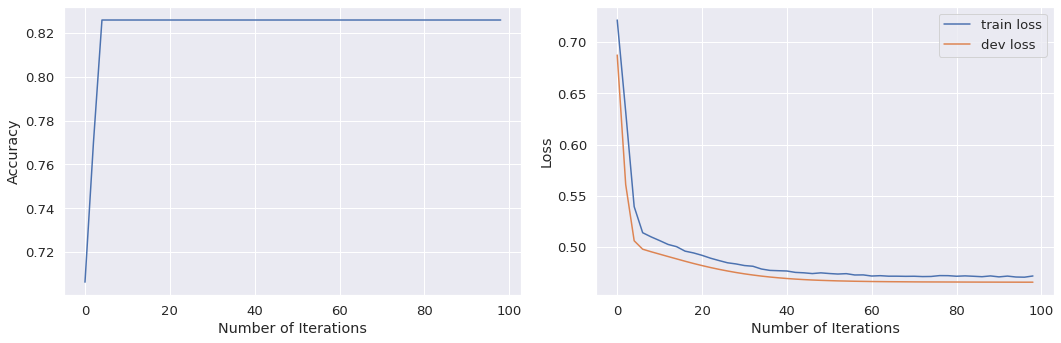

In [ ]:
import warnings
warnings.filterwarnings("ignore")
fig, ((ax1, ax2))= plt.subplots(1,2,figsize = (15,5))
x_axis = [i*2 for i in range(len(dev_losses))]
sns.lineplot(x_axis, dev_acc_list, ax = ax1)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Number of Iterations")
sns.lineplot(x_axis, train_losses, ax = ax2, label = 'train loss')
sns.lineplot(x_axis, dev_losses, ax = ax2, label = 'dev loss')
ax2.set_ylabel("Loss")
ax2.set_xlabel("Number of Iterations")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
class BiLSTM_Attention(nn.Module):

    def __init__(self, embedding_dim, pretrained_emb, hidden_dim, n_layers, token_size, USE_GLOVE=True):

        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=token_size,
            embedding_dim=embedding_dim
        )
        if USE_GLOVE:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_emb).type(torch.float))

        # self.token_size = token_to_ix.__len__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.5)

        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.w_omega = nn.Parameter(torch.Tensor(hidden_dim * 2, hidden_dim * 2))
        self.u_omega = nn.Parameter(torch.Tensor(hidden_dim * 2, 1))

        nn.init.uniform_(self.w_omega, -0.1, 0.1)
        nn.init.uniform_(self.u_omega, -0.1, 0.1)


    def attention_net(self, x):       #x:[batch, seq_len, hidden_dim*2]

        u = torch.tanh(torch.matmul(x, self.w_omega))         #[batch, seq_len, hidden_dim*2]
        att = torch.matmul(u, self.u_omega)                   #[batch, seq_len, 1]
        att_score = F.softmax(att, dim=1)

        scored_x = x * att_score                              #[batch, seq_len, hidden_dim*2]

        context = torch.sum(scored_x, dim=1)                  #[batch, hidden_dim*2]
        return context

    def forward(self, x):
        # print('lan x.shape',x.shape)
        embedding = self.dropout(self.embedding(x))       #[seq_len, batch, embedding_dim]
        # print(embedding.shape)
        embedding = torch.transpose(embedding,0,1)
        # print('embedding',embedding.shape)
        # output: [seq_len, batch, hidden_dim*2]     hidden/cell: [n_layers*2, batch, hidden_dim]
        output, (final_hidden_state, final_cell_state) = self.rnn(embedding)
        output = output.permute(1, 0, 2)                  #[batch, seq_len, hidden_dim*2]
        attn_output = self.attention_net(output)
        # print(attn_output.shape)
        logit = self.fc(attn_output)
        # print('logit',logit.shape)
        return logit
        # return attn_output

In [ ]:
LEARNING_RATE = 0.001

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = BiLSTM_Attention(pretrained_emb.shape[1], pretrained_emb, hidden_dim=32, n_layers=2, token_size=len(token2ix)).to(device)
# opt = optimizer.Adam(net.parameters(), lr=LEARNING_RATE)
opt = optimizer.SGD(net.parameters(), lr=LEARNING_RATE)
# criteon = nn.CrossEntropyLoss().to(device)
criteon = nn.BCEWithLogitsLoss().to(device)
train_losses, dev_losses, dev_acc_list, best_model = train(11,train_data_iter, dev_data_iter ,opt,criteon,net,device)